In [1]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
nltk.data.path
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline
import os
import psycopg2 as pg
from sqlalchemy import create_engine
import plotly.express as px

In [2]:
#db settings
host = 'database-airbnb.cl4bob5uux9z.us-west-1.rds.amazonaws.com'
dbname= 'postgres'
user ='postgres'
port = 5432
password ='*****'

# PYTHON FUNCTION TO CONNECT TO THE POSTGRESQL DATABASE AND
# RETURN THE SQLACHEMY ENGINE OBJECT
def get_connection():
    return create_engine(
        url="postgresql://{0}:{1}@{2}:{3}/{4}".format(
            user, password, host, port, dbname
        )
    )
  
  
if __name__ == '__main__':
  
    try:
        # GET THE CONNECTION OBJECT (ENGINE) FOR THE DATABASE
        engine = get_connection().execution_options(stream_results=True)
        print(
            f"Connection to the {host} for user {user} created successfully.")
    except Exception as ex:
        print("Connection could not be made due to the following error: \n", ex)

Connection to the database-airbnb.cl4bob5uux9z.us-west-1.rds.amazonaws.com for user postgres created successfully.


In [3]:
reviews = pd.read_sql_query("SELECT listing_id, reviewer_id, comments FROM reviews", con=engine, chunksize=1000000)

In [4]:
listings = pd.read_sql_query("SELECT * FROM listings", con=engine)

In [5]:
chunk_list = []

for chunk in reviews:
    chunk_list.append(chunk)

df_concat = pd.concat(chunk_list)

In [6]:
listings_comments = listings.merge(df_concat[['listing_id', 'reviewer_id', 'comments']], left_on='id', right_on='listing_id', how='left')

In [7]:
listings_comments = listings_comments.drop('listing_id', axis=1)

In [8]:
listings_comments.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,avg_score_rating,reviewer_id,comments
0,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,172428041.0,Had a great stay! Apartment was clean
1,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,105372084.0,Wir waren absolut zufrieden mit der Unterkunft...
2,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,167068129.0,"Foi tudo excelente, tudo preparado com muito c..."
3,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,61028695.0,"Отличная светлая квартира, расположение прекра..."
4,23968985.0,Apartment24-Breitensee 200m away from Metro U3,756858.0,Manfred,Penzing,48.20167,16.31326,Entire home/apt,50.0,5.0,...,4.96,4.87,4.78,4.91,4.78,4.91,1,4.85,34967551.0,I had an incredible 2.5 month stay at Manfred’...


In [9]:
#float format change
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [10]:
text_df = listings_comments[['avg_score_rating', 'comments']]
text_df.comments.isna().sum()

1824

In [11]:
text_df = text_df[~text_df.comments.isna()]
text_df = text_df[~text_df.avg_score_rating.isna()]

In [12]:
text_df['avg_score_rating'].value_counts(normalize=True)

4.88000   0.05271
4.89000   0.04734
4.86000   0.04695
4.87000   0.04691
4.91000   0.03928
            ...  
2.33000   0.00000
0.57000   0.00000
2.00000   0.00000
2.93000   0.00000
1.43000   0.00000
Name: avg_score_rating, Length: 170, dtype: float64

In [13]:
text_df['comment_length'] = text_df['comments'].apply(len)
print(text_df.shape)
text_df.head()

(1144965, 3)


,avg_score_rating,comments,comment_length
0,4.85000,Had a great stay! Apartment was clean,37
1,4.85000,Wir waren absolut zufrieden mit der Unterkunft...,182
2,4.85000,"Foi tudo excelente, tudo preparado com muito c...",124
3,4.85000,"Отличная светлая квартира, расположение прекра...",369
4,4.85000,I had an incredible 2.5 month stay at Manfred’...,522


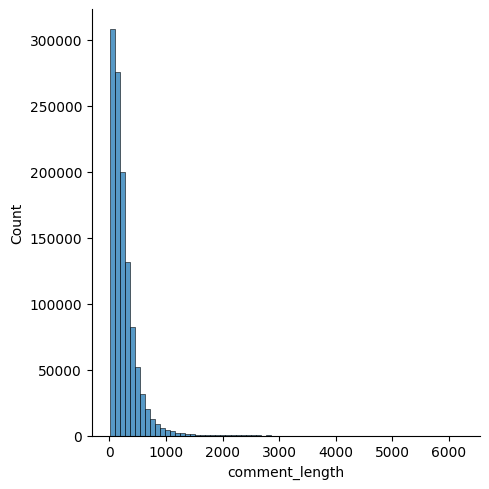

In [14]:
sns.displot(data=text_df['comment_length'], x=text_df['comment_length'], kind='hist', bins=70)


In [15]:
#avg score is 4.80
df_high_score = text_df[text_df['avg_score_rating'] >= 4.80]
df_low_score = text_df[text_df['avg_score_rating'] < 3.50]

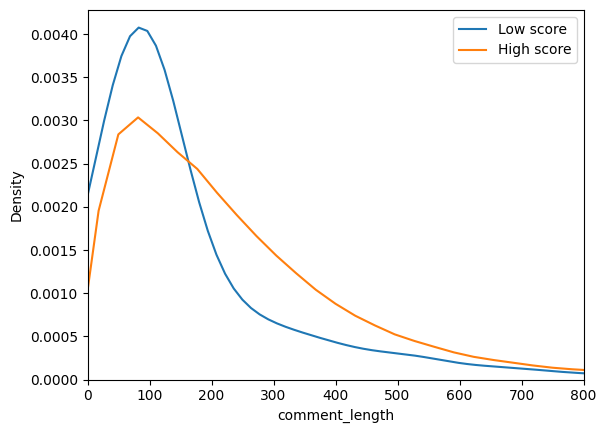

In [16]:
sns.kdeplot(data=df_low_score['comment_length'], label='Low score')
sns.kdeplot(data=df_high_score['comment_length'], label='High score')
plt.xlim(0,800)
plt.legend()

Exclamation counter:

In [17]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [18]:
text_df['count_exc'] = text_df['comments'].apply(count_exclamation_mark)
text_df.head(5)

,avg_score_rating,comments,comment_length,count_exc
0,4.85000,Had a great stay! Apartment was clean,37,1
1,4.85000,Wir waren absolut zufrieden mit der Unterkunft...,182,0
2,4.85000,"Foi tudo excelente, tudo preparado com muito c...",124,1
3,4.85000,"Отличная светлая квартира, расположение прекра...",369,1
4,4.85000,I had an incredible 2.5 month stay at Manfred’...,522,4


In [19]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count   1144965.00000
mean          0.65799
std           1.14733
min           0.00000
20%           0.00000
40%           0.00000
50%           0.00000
60%           0.00000
80%           1.00000
max          59.00000
Name: count_exc, dtype: float64

<AxesSubplot: >

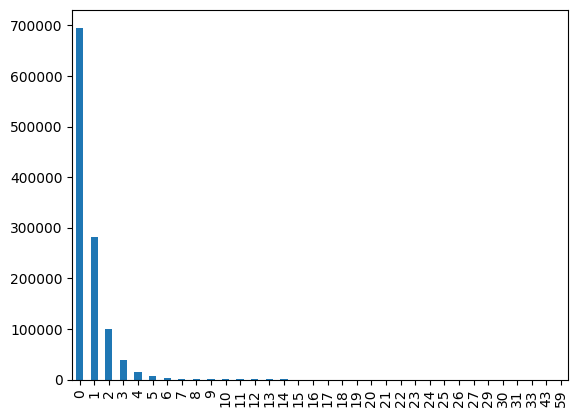

In [20]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [21]:
text_df[text_df['count_exc']== 59].index

Int64Index([780802, 780888, 780984], dtype='int64')

In [22]:
text_df['comments'][780984]

"Halli Hallo liebe Airbnb Community <br/>Ich war in Wien 5 Tage und habe bei Karin gewohnt. Hier sage ich wie meine Erfahrung bei Karin war: <br/>1)\tKarin ist eine tolle warmherzliche Gastgeberin. Sie hat sich um jedes Detail gekümmert damit ich alle notwendigen Sachen hatte und mich wohl gefühlt habe!! Sie ist nett, zuvorkommend, Hilfsbereit und mann fühlt sich sofort bei Ihr willkommen. Sie hat mich mit offene Ärme und mit einem leckerem Sekt empfangen.  Sie kennt sich echt super gut aus in Wien und hat mir ein paar tollen Tipps gegeben, die sehr Hilfsreich waren. Ich werde ewig mit ihr dankbar sein für ihre Hospitalität und dass ich in ihre Wohnung wohnen durfte.<br/>2)\tDie Wohnung ist ein Traum! Eine tolle Altbau Wohnung, mit Hohe decken und viel Licht. Die Wohnung hat den ganzen österreichischen Charm, Ist super sauber, fine und geschmackvoll eingerichtet, und vor allem das Haus und ihren Hinterhof sind Super süß! <br/>3)\tDie Umgebung ist einfach TOP!!! Mann ist mitten drin abe

##### Text polarity

Polarity is the emotion expressed in the sentence. It can be positive, neagtive and neutral. <br>

The polarity score is a float within the range [-1.0, 1.0]

In [23]:
text_df['polarity'] = text_df['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,avg_score_rating,comments,comment_length,count_exc,polarity
0,4.85000,Had a great stay! Apartment was clean,37,1,0.68333
1,4.85000,Wir waren absolut zufrieden mit der Unterkunft...,182,0,0.00000
2,4.85000,"Foi tudo excelente, tudo preparado com muito c...",124,1,0.41667
3,4.85000,"Отличная светлая квартира, расположение прекра...",369,1,0.00000
4,4.85000,I had an incredible 2.5 month stay at Manfred’...,522,4,0.50938


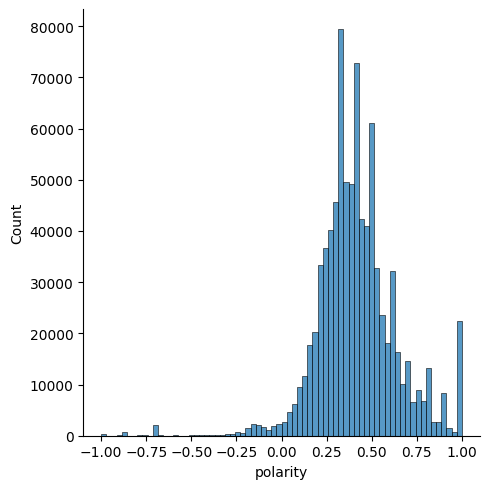

In [24]:
df_polarity_no_zero = text_df[text_df['polarity'] != 0]
sns.displot(data=df_polarity_no_zero['polarity'], kind='hist', bins=70)

In [25]:
text_prep = text_df.copy()

#### Preprocessing - text features

Dropping punctuation

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [28]:
text_prep['comments'] = text_prep['comments'].apply(punctuation_removal)
text_prep['comments'].head()

0                 Had a great stay Apartment was clean
1    Wir waren absolut zufrieden mit der Unterkunft...
2    Foi tudo excelente tudo preparado com muito ca...
3    Отличная светлая квартира расположение прекрас...
4    I had an incredible 25 month stay at Manfred’s...
Name: comments, dtype: object

#### WordCloud - Repetition of words

In [29]:
high_score_df = text_prep[text_prep.avg_score_rating >= 3]
low_score_df = text_prep[text_prep.avg_score_rating < 3]
high_score_df.head(5)

,avg_score_rating,comments,comment_length,count_exc,polarity
0,4.85000,Had a great stay Apartment was clean,37,1,0.68333
1,4.85000,Wir waren absolut zufrieden mit der Unterkunft...,182,0,0.00000
2,4.85000,Foi tudo excelente tudo preparado com muito ca...,124,1,0.41667
3,4.85000,Отличная светлая квартира расположение прекрас...,369,1,0.00000
4,4.85000,I had an incredible 25 month stay at Manfred’s...,522,4,0.50938


In [30]:
high_rating_words = []
low_rating_words = []

for comment in high_score_df.comments:
    high_rating_words.append(comment)
high_rating_words = ' '.join(high_rating_words)


for comment in low_score_df.comments:
    low_rating_words.append(comment)
low_rating_words = ' '.join(low_rating_words)


#### Positive reviews

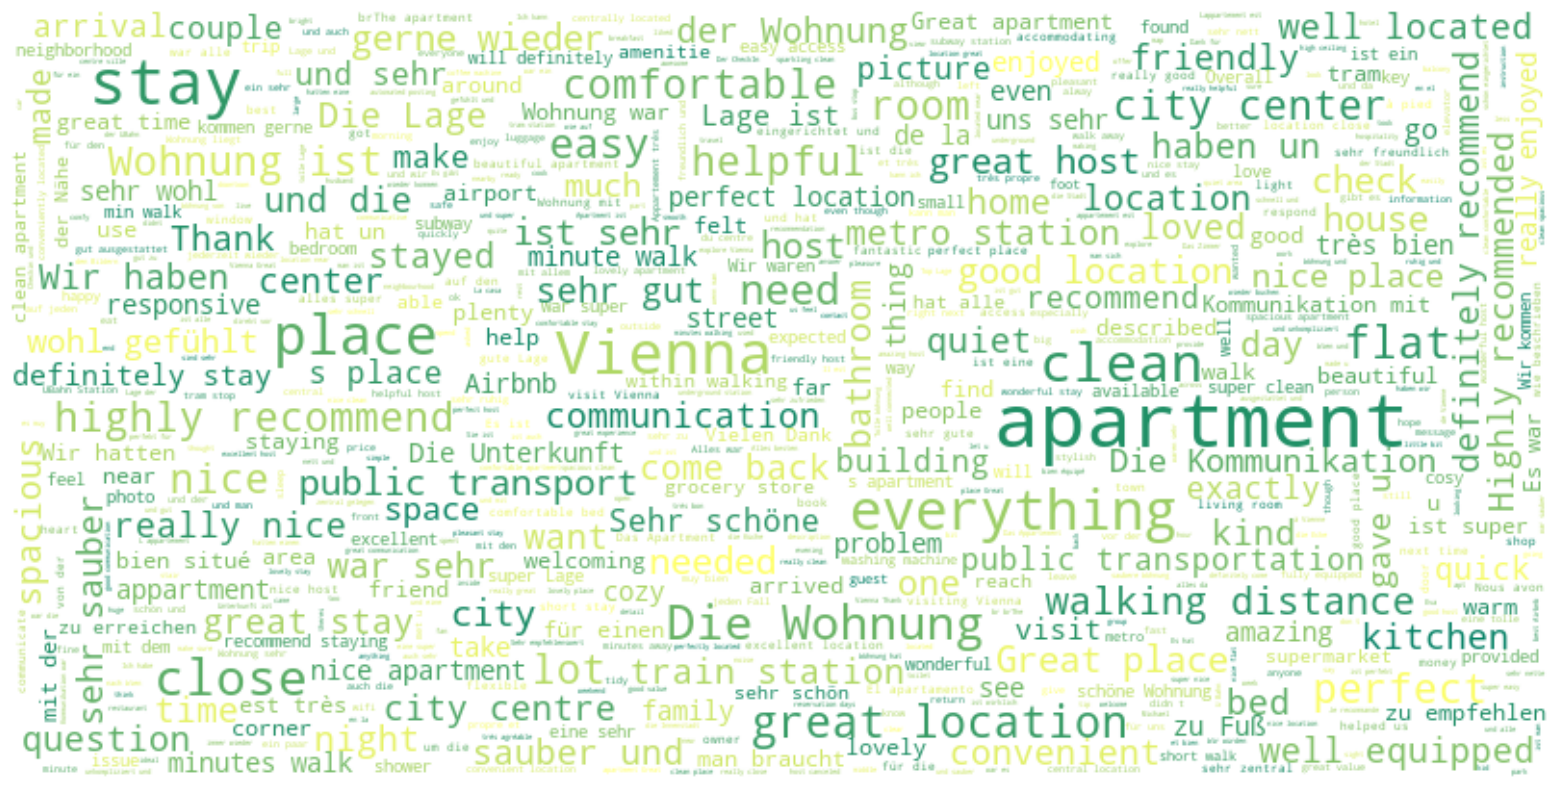

In [31]:
wordcloud = WordCloud().generate(high_rating_words)

wordcloud = WordCloud(background_color="white",max_words=len(high_rating_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer', width=800, height=400).generate(high_rating_words)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

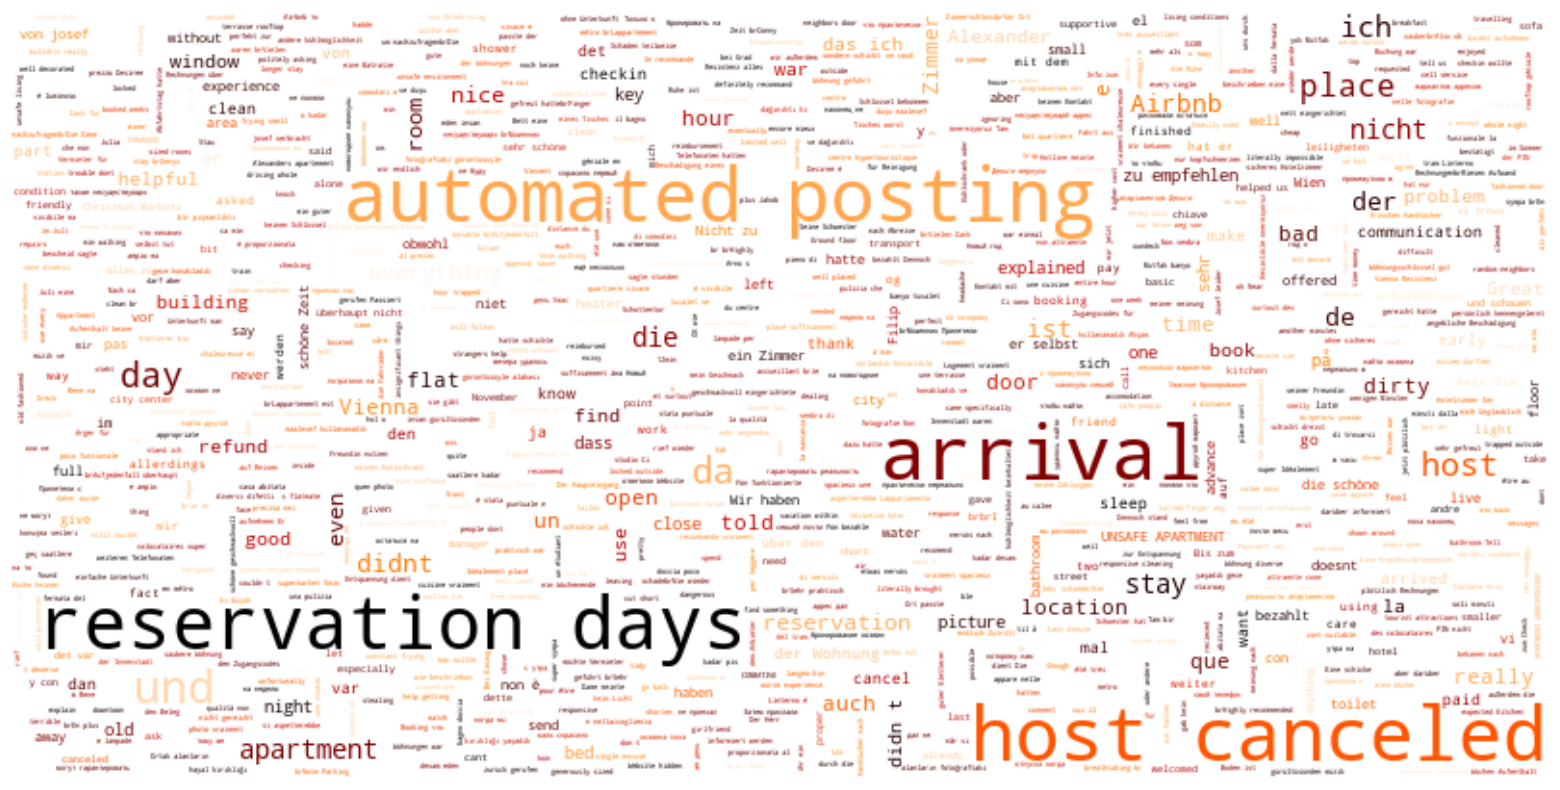

In [32]:
wordcloud = WordCloud().generate(low_rating_words)

wordcloud = WordCloud(background_color="white",max_words=len(low_rating_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat', width=800, height=400).generate(low_rating_words)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()